**Objective**: Measure how vulnerable the reservoir is to pertubation.

A small pertubation is added directly after the burn in period. \
Then the euclidean distance between the perturbed and the original reservoirs states is measured. \
Finally the Lyapunov Exponents are calculated.

In [1]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params
import matplotlib.pyplot as plt
from agent import Reservoir
from tqdm.notebook import tqdm
from config import DATA_PATH
from pathlib import Path

folder = 'dynamical_stability'
path = Path(DATA_PATH) / folder
path.mkdir(parents=True, exist_ok=True)

colormap = plt.get_cmap('tab20c')
colors = [plt.cm.tab20c.colors[i] for i in range(0, 20, 2)][:11]

### 1. Method Used by Boedecker et al. in the 'Information processing in echo state networks at the edge of chaos' paper

In [2]:
sigma_range = list(np.arange(0.025, 0.045, 0.001))
time_steps = 1000
num_reservoirs = 20
repeats_per_reservoir = 500
perturbation_strength = 1e-12
lyapunov_exponents_means = []

for sigma in tqdm(sigma_range):

    # for each reservoir and each repeat per reservoir calculate a single lambda_n value
    lambda_n_values = np.asarray([])

    for _ in range(num_reservoirs):

        baseline_reservoir = Reservoir(time_steps=time_steps, standard_deviation=sigma)
        perturbed_reservoir = Reservoir(time_steps=time_steps, standard_deviation=sigma)
        perturbed_reservoir.weight_matrix = baseline_reservoir.weight_matrix.copy()

        for _ in range(repeats_per_reservoir):
            distances = np.asarray([])
            perturbed_initial_state = baseline_reservoir.burn_in_state_matrix[-1].copy()
            perturbed_initial_state[np.random.randint(0, baseline_reservoir.num_neurons)] += perturbation_strength
            perturbed_reservoir.neuron_state_time_matrix[0] = perturbed_initial_state
            for t in range(1, time_steps):
                perturbed_reservoir.neuron_state_time_matrix[t] = np.tanh(np.dot(perturbed_reservoir.weight_matrix, perturbed_reservoir.neuron_state_time_matrix[t - 1]))
                dist = np.linalg.norm(baseline_reservoir.neuron_state_time_matrix[t] - perturbed_reservoir.neuron_state_time_matrix[t])
                perturbed_reservoir.neuron_state_time_matrix[t] = baseline_reservoir.neuron_state_time_matrix[t] + (perturbation_strength/dist)*(perturbed_reservoir.neuron_state_time_matrix[t]-baseline_reservoir.neuron_state_time_matrix[t])
                distances = np.append(distances, dist)
            lambda_n_values = np.append(lambda_n_values, np.mean(np.log(distances / perturbation_strength)))

    lyapunov_exponents_means.append(np.mean(lambda_n_values))

  0%|          | 0/20 [00:00<?, ?it/s]

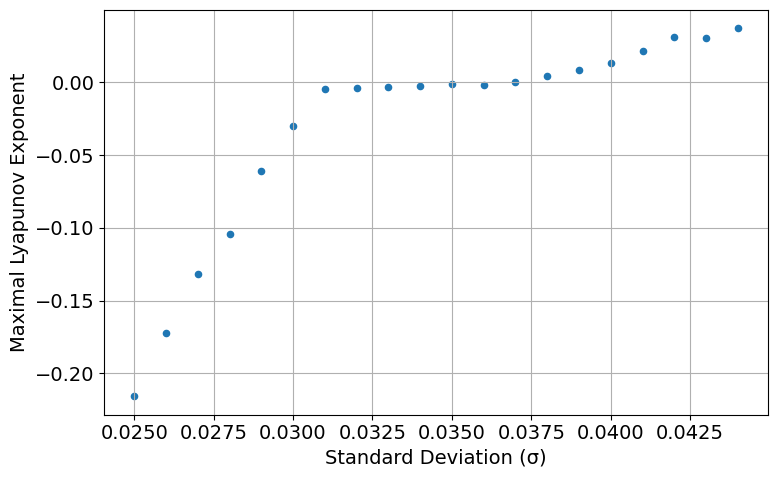

In [9]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.grid()
plt.scatter(sigma_range, lyapunov_exponents_means, s=20)
plt.xlabel('Standard Deviation (σ)')
plt.ylabel(f'Maximal Lyapunov Exponent')
plt.tight_layout()
plt.savefig(path / 'lyapunov_exponents_boedecker.pdf', format='pdf')

### 2. Self-Made Method (Deprecated)

  0%|          | 0/10 [00:00<?, ?it/s]

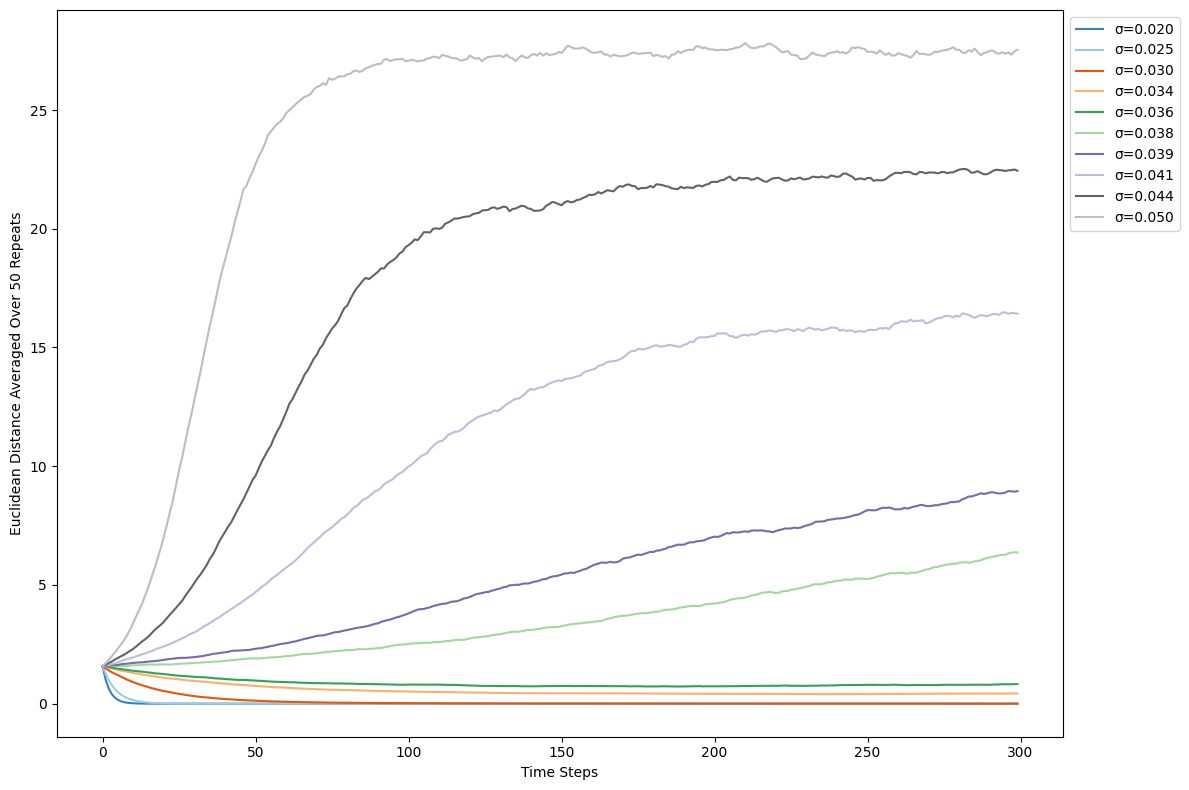

In [ ]:
sigma_range = [0.02, 0.025, \
               0.03, 0.034, 0.036, 0.038, 0.039, \
               0.041, 0.044, 0.05]
time_steps = 300
repeats_per_sigma = 50
perturbation_strength = 0.05
end_idx = 50
delta_t = 1

distances_for_all_sigmas = []

for sigma in tqdm(sigma_range):
    averaged_distances = []
    for repeat in range(repeats_per_sigma):
        distances = []
        # original reservoir
        baseline_reservoir = Reservoir(time_steps=time_steps, standard_deviation=sigma)
        # perturbed reservoir with same weight matrix as original one
        perturbed_reservoir = Reservoir(time_steps=time_steps, standard_deviation=sigma)
        perturbed_reservoir.weight_matrix = baseline_reservoir.weight_matrix.copy()
        perturbed_initial_state = baseline_reservoir.burn_in_state_matrix[-1] + np.random.normal(0, perturbation_strength, baseline_reservoir.num_neurons)
        perturbed_reservoir.neuron_state_time_matrix[0] = perturbed_initial_state
        for t in range(1, time_steps):
            perturbed_reservoir.neuron_state_time_matrix[t] = np.tanh(np.dot(perturbed_reservoir.weight_matrix, perturbed_reservoir.neuron_state_time_matrix[t - 1]))
        # calculate Euclidean distance over time
        for t in range(time_steps):
            dist = np.linalg.norm(baseline_reservoir.neuron_state_time_matrix[t] - perturbed_reservoir.neuron_state_time_matrix[t])
            distances.append(dist)
        averaged_distances.append(distances)
    averaged_distances = np.mean(averaged_distances, axis=0)
    distances_for_all_sigmas.append(np.array(averaged_distances))

plt.figure(figsize=(12,8))
for i, sigma in enumerate(sigma_range):
    plt.plot(distances_for_all_sigmas[i], label=f'σ={sigma:.3f}', color=colors[i])
plt.xlabel('Time Steps')
plt.ylabel(f'Euclidean Distance Averaged Over {repeats_per_sigma} Repeats')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig(path / 'dynamical_stability.svg', format='svg', bbox_inches='tight')

For the Lyapunov exponents consider the equation
$$
|\boldsymbol{\delta}(t)|\approx e^{\lambda t}|\boldsymbol{\delta}_0|
$$
take the natural logarithm on both sides gives
$$
\ln(\boldsymbol{\delta}(t))|\approx \lambda t + \ln(|\boldsymbol{\delta}_0|)
$$
which is in the form $y=mx+b$, so a line can be fitted where the slope is the largest Lyapunov exponent.

This will return only the largest Lyapunov exponent because it is the one that dominates how to system evolves.

Before this can be done we have to estimate the range for which the curves follow a linear relationship (before they bend over).
This value is chosen by visual inspection and named end_idx.

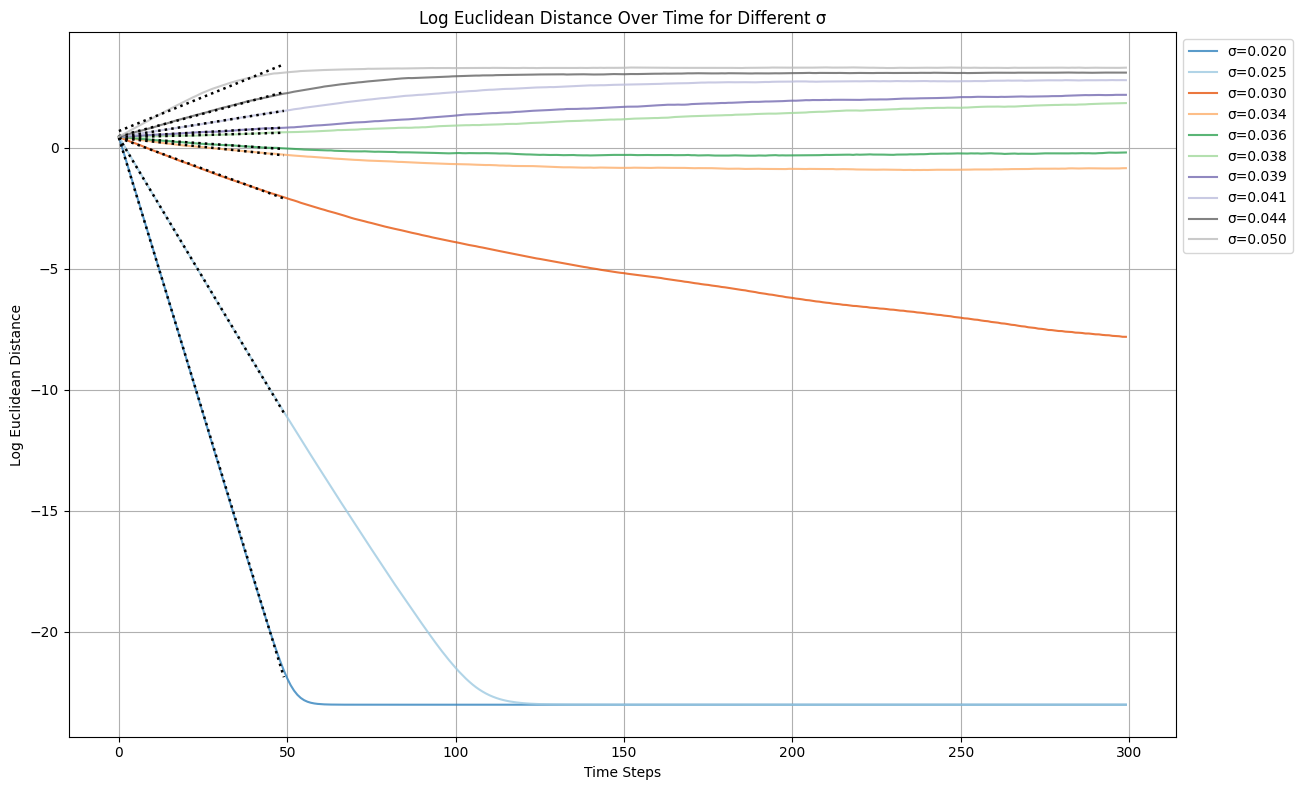

In [ ]:
plt.figure(figsize=(12, 8))
plt.xlabel('Time Steps')
plt.ylabel('Log Euclidean Distance')
plt.title('Log Euclidean Distance Over Time for Different σ')
plt.grid()
plt.tight_layout()

def calculate_lyapunov_exponent(distances):
    time_steps = np.arange(0, end_idx) * delta_t
    # logarithmize the distances, but avoid log(0)
    log_distances = np.log(distances[0:end_idx] + 1e-10)
    plt.plot(np.log(distances + 1e-10), label=f'σ={sigma_range[i]:.3f}', alpha=0.8, color=colors[i])
    # linear fit
    slope, intercept = np.polyfit(time_steps, log_distances, deg=1)
    plt.plot(time_steps, slope * time_steps + intercept, linestyle='dotted', color='black', linewidth=1.8)
    return slope

lyapunov_exponents = [] 
for i, sigma in enumerate(sigma_range):
    lambda_max = calculate_lyapunov_exponent(distances_for_all_sigmas[i])
    lyapunov_exponents.append(lambda_max)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig(path / 'log_distances.svg', format='svg', bbox_inches='tight')
plt.show()

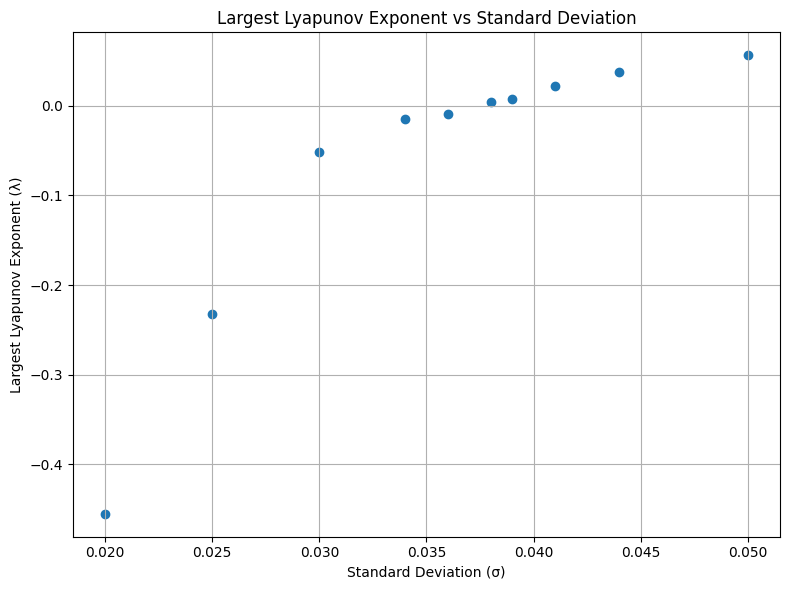

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(sigma_range, lyapunov_exponents, marker='o')
plt.xlabel('Standard Deviation (σ)')
plt.ylabel('Largest Lyapunov Exponent (λ)')
plt.title('Largest Lyapunov Exponent vs Standard Deviation')
plt.grid()
plt.tight_layout()
plt.savefig(path / 'lyapunov_exponent.svg', format='svg', bbox_inches='tight')